# Signal construction and helper functions for the frequency content class 


In [1]:
import numpy as np
from scipy import fft
import matplotlib.pyplot as plt

In [2]:
def create_signal(fs,N):
    """ create a secret periodic signal with a Gaussian noise"""
    dt = 1./fs
    t = np.linspace(0,N*dt,N)
    y = 3.0+3.0*np.sin(2*np.pi*10*t)+1.2*np.sin(2*np.pi*24*t) # this is a secret function 
    noise = np.random.normal(0,1,N)
    y += noise
    return t, y

In [3]:
def spectrum(y,Fs):
    """
    Plots a Single-Sided Amplitude Spectrum of a sampled
    signal y(t), sampling frequency Fs (lenght of a signal 
    provides the number of samples recorded)
    
    Following: http://goo.gl/wRoUn
    """
    n = len(y) # length of the signal
    k = np.arange(n)
    T = n/Fs
    frq = k/T # two sides frequency range
    frq = frq[range(np.int(n/2))] # one side frequency range
    Y = 2*fft(y)/n # fft computing and normalization
    Y = Y[range(np.int(n/2))]
    return (frq, Y)

In [4]:
def plotSignal(t,y,fs):
    """ plots the time signal Y(t) and the 
    frequency spectrum Y(fs), after removing
    the DC component, Y.mean() 
    Inputs:
        t - time signal, [sec]
        Y - values, [Volt]
        fs - sampling frequency, [Hz]
    Outputs:
        plot with two subplots: y(t) and the spectrum Y(f) 
    Usage:
        fs = 30, N = 256
        t,y = create_signal(fs,N)
        plotSignal(t,y,fs,N)
    """
    # t,y = create_signal(fs,N)
    y = y - y.mean()
    frq,Y = spectrum(y,fs) 
    
    # Plot
    plt.figure()
    plt.subplot(2,1,1)
    plt.plot(t,y,'b-')
    plt.xlabel('$t$ [s]')
    plt.ylabel('$Y$ [V]')
    # axes().set_aspect(0.2)
    # title('sampled signal')
    plt.subplot(2,1,2)
    plt.plot(frq,abs(Y),'r') # plotting the spectrum
    plt.xlabel('$f$ (Hz)')
    plt.ylabel('$|Y(f)|$')    

In [5]:
def sampling(t,y,fs):
    """ sampling of a signal y(t) at frequency fs [Hz]
    inputs:
        t  - time signal [s], array of floats, dense sampled
        y  - signal [Volt], array of floats
        fs  - sampling frequency [Hz], float
    """
    dt = 1./fs
    ts = np.arange(t[0],t[-1],dt)
    # ts = np.linspace(t[0],t[-1],(t[-1]-t[0])/dt)
    ys = np.interp(ts,t,y,left=0.0,right=0.0)

    return ts,ys

In [6]:
def quantization(ys,N):
    """quantization of a signal
    inputs:
        ts - time signal [s], array
        ys - signal [Volt], array
        N  - number of bits, scalar (2,4,8,12,...)
    outputs:
        yq - digitized signal at N bits
    """
        #quantization
    # N = 4 # number of bits
    max_value = 2**(N-1) - 1
    yq = (ys*(max_value)).astype(np.int32)/(max_value)
    return yq

In [7]:
def clipping(y,miny=-5,maxy=5):
    """ clipping of signal 
    inputs: 
        y - signal [V] array of floats
        miny, maxy - lowest, highest values [V], scalar floats, default -5 ..+5 [Volt]
    outputs:
        y - clipped signal [V]
    better use: numpy.clip 
    """
    y[y < miny] = miny
    y[y > maxy] = maxy
    return y

In [8]:
def find_nearest(array, values):
    index = np.abs(np.subtract.outer(array, values)).argmin(0)
    return array[index]

In [9]:
# sample and hold
from scipy.interpolate import interp1d

def adc(t,y,fs=1.,N=4,miny=-5.,maxy=5.,method=None):
    """ A/D conversion
    Inputs:
        t - time [s] array of floats,
        y - signal [V] array of floats,
        fs - sampling frequency [Hz], scalar float,
        N - number of bits of the A/D converter, (2,4,8,12,14,...)
        miny, maxy - lowest, highest values [V], scalar floats, default -5 ..+5 [Volt]
        method - the reconstruction method: 'zoh' = zero-and-hold, 'soh' - sample and hold or None
    outputs:
        ts - sampled times [s]
        yq - sampled and digitized signal [V]
        yr - reconstructed, sample-and-hold signal [V]
    Usage:
        t = np.linspace(0,10, 10000)
        y = 5+np.sin(2*np.pi*1*t)
        ts,yq,yr = adc(t,y,fs=4,N=14,miny=0,maxy=10) # monopolar
        plt.figure()
        plt.plot(t,y,'k--',lw=0.1)
        plt.plot(ts,yq,'ro')
        plt.plot(t, yr,'b-')
    """
    # first sample
    ts,ys = sampling(t,y,fs)
    # clipping
    ys = clipping(ys,miny,maxy)
    # digitize
    yq = quantization(ys,N)
    # sample and hold reconstruction
    if method == 'soh':
        tr = t
        soh = interp1d(ts, yq, kind='zero', bounds_error=False,fill_value=yq[-1])
        yr = soh(tr)
    elif method == 'zoh':
        tr = t
        yr = np.zeros_like(tr)
        index = np.abs(np.subtract.outer(tr, ts)).argmin(0)
        yr[index] = yq
    elif method is None:
        tr = ts
        yr = yq
    else:
        raise(ValueError)
        
    return ts,yq,tr,yr

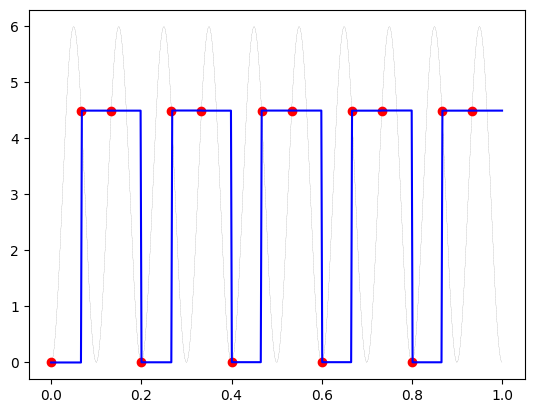

In [10]:
# example
t = np.linspace(0,1.,500)
y = 3+3*np.sin(2*np.pi*10*t-np.pi/2.)

ts,yq,tr,yr = adc(t,y,fs=15,N=12,miny=0,maxy=10,method='soh') # monopolar
plt.figure()
plt.plot(t,y,'k--',lw=0.1)
plt.plot(ts,yq,'ro')
plt.plot(tr, yr,'b-')